In [174]:
import torch
from torch.optim import SGD, Adam
import torch.nn as nn


from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np

In [175]:
INPUT_DIMENSION=2
OUTPUT_DIMENSION=1
NUMBER_OF_SAMPLES=1000
EPOCHS=20
LR=0.01

In [176]:
X,y=make_blobs(n_samples=1000, centers=2, random_state=1)

# Make the categories +/-1 rather thn 0,1
y=2*y-1 

# Transform the entries to have norm less than or equal to 1
X=X/max([np.linalg.norm(x) for x in X]) 

# Split data into train and test
(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.15)
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

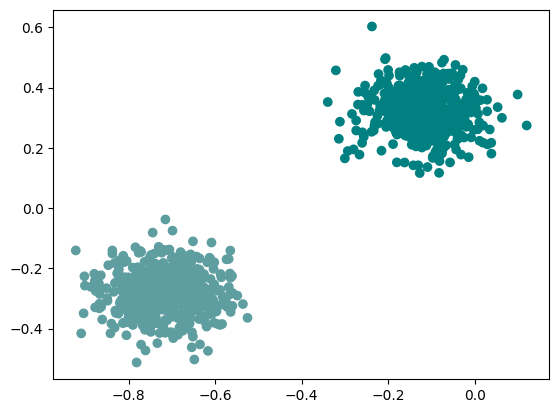

In [177]:
colors=np.full(len(y), 'cadetblue')
colors[y==-1]='teal'
plt.scatter(X[:,0],X[:,1],c=colors)

In [178]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=2, output_dim=1):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)

  def forward(self, x):
    x = self.linear(x)
    return x

In [179]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

In [180]:
model=LinearClassifier()

In [181]:
# Train the model

opt = Adam(model.parameters(), lr=LR)
lossFunc = nn.L1Loss()

for epoch in range(0, 20):
	trainLoss = 0
	trainAcc = 0
	samples = 0
	model.train()
	for (batchX, batchY) in next_batch(trainX, trainY, 1):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainLoss += loss.item() * batchY.size(0)
		trainAcc += (torch.sign(predictions) == batchY).sum().item()
		samples += batchY.size(0)
	print("Epoch: {} train loss: {:.3f} train accuracy: {:.3f}".format(epoch+1,trainLoss / samples,trainAcc / samples))

Epoch: 1 train loss: 0.339 train accuracy: 0.951
Epoch: 2 train loss: 0.178 train accuracy: 1.000
Epoch: 3 train loss: 0.178 train accuracy: 1.000
Epoch: 4 train loss: 0.178 train accuracy: 1.000
Epoch: 5 train loss: 0.178 train accuracy: 1.000
Epoch: 6 train loss: 0.178 train accuracy: 1.000
Epoch: 7 train loss: 0.178 train accuracy: 1.000
Epoch: 8 train loss: 0.178 train accuracy: 1.000
Epoch: 9 train loss: 0.178 train accuracy: 1.000
Epoch: 10 train loss: 0.178 train accuracy: 1.000
Epoch: 11 train loss: 0.178 train accuracy: 1.000
Epoch: 12 train loss: 0.178 train accuracy: 1.000
Epoch: 13 train loss: 0.178 train accuracy: 1.000
Epoch: 14 train loss: 0.178 train accuracy: 1.000
Epoch: 15 train loss: 0.178 train accuracy: 1.000
Epoch: 16 train loss: 0.178 train accuracy: 1.000
Epoch: 17 train loss: 0.178 train accuracy: 1.000
Epoch: 18 train loss: 0.178 train accuracy: 1.000
Epoch: 19 train loss: 0.178 train accuracy: 1.000
Epoch: 20 train loss: 0.178 train accuracy: 1.000


In [182]:
model.eval()
with torch.no_grad():
    for batchX, batchY in next_batch(testX, testY, len(testX)):
        predictions = model(batchX)
        margin=min(abs(predictions.max(1)[0])).tolist()
print(margin)

0.4342138171195984


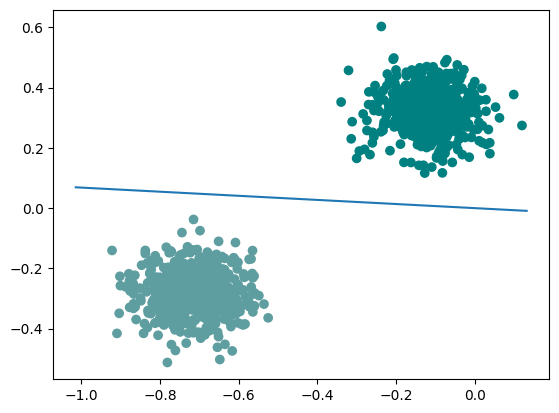

In [183]:
# For INPUT_DIMENSION=2 plot decision boundary

for param in model.parameters():
    decision_vector=param[0].tolist()
    decision_vector=decision_vector/np.linalg.norm(decision_vector)
x=np.array([min(X[:,0])*1.1,max(X[:,0])*1.1])
grad=decision_vector[1]/decision_vector[0]
plt.plot(x,-x/grad)
plt.scatter(X[:,0],X[:,1],c=colors)

In [184]:
compressed_decision_vector=np.zeros(len(decision_vector))
for k, comp in enumerate(decision_vector):
    p=8*comp**2/margin**2
    print(p)
    if np.random.random()<p:
        compressed_decision_vector[k]=margin**2/(8*comp)

0.1964970966186133
42.2344483612791


In [185]:
print(decision_vector)

[-0.06805135 -0.99768182]


In [186]:
print(compressed_decision_vector)

[ 0.         -0.02362247]


C:\Users\thoma\AppData\Local\Temp\ipykernel_22868\3456812112.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  compressed_grad=compressed_decision_vector[1]/compressed_decision_vector[0]


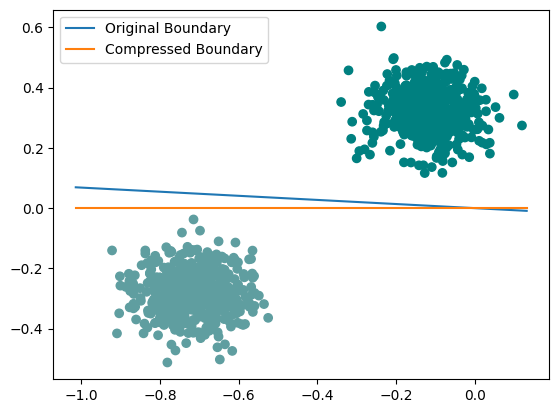

In [188]:
compressed_grad=compressed_decision_vector[1]/compressed_decision_vector[0]
plt.plot(x,-x/grad,label='Original Boundary')
plt.plot(x,-x/compressed_grad,label='Compressed Boundary')
plt.scatter(X[:,0],X[:,1],c=colors)
plt.legend()